## Yennie Jun Fundamentals of Social Data Science Summative

TODO Justify all of the decisions you make for what data you decide
I would prefer more discussion of data quality and why some data were included or not than a discussion of complex modelling which you should probably save for your stats cours

# Part 1

## Setup [750 words]

### Literature Review
The United States and South Korea experienced their first case of the COVID-19 virus on January 20, 2020 (Holsue, 2020; Lim, 2020). Despite this, the two countries have had vastly different experiences dealing with the virus. The US has experienced over ten million total cases and over 200,000 deaths related to the virus. In August, the US was found to account for 25 percent of COVID-19 cases and deaths in the world while comprising less than 5% of the global population (Florida Atlantic University, 2020). South Korea, on the other hand, managed to flatten the curve early on, emerging as a "model to emulate in fighting the pandemic" (You, 2020).

[ existing lit review about SK and US government covid? ] 

The question I would like to answer is: **How fast did the South Korean and United States governments respond after the first case of COVID-19 in each country (January 20, 2020 for both), with respect to different government response indicators?** These indicators are dervied from the Oxford COVID-19 Government Response Tracker (Mahdi et al, 2020). More details about the specific indicators are listed in the [GitHub codebook](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md) for the `government response` table (Codebook, 2020). Upon examination, I decided to look specifically at the "Containment and closure policies", which are the policies that mention closures of various institutions (i.e. schools, workplaces, etc). A follow-up question I would like to answer involves asking if faster government response leads to a more successful Covid containment "success" story, at least in the context of these two countries. 

### Data Exploration
To begin the data analysis process, I will begin by loading in the `government_response` table from the OxCovid Database using a SQL query, filtering just for the United States and South Korea. I will calculate the "days since first infection" by subtracting each "government response" entry from `2020-01-20`. Because my question involves the initial response of these countries' governments to covid, I am interested in looking at the first few months, and will therefore load in all data before May 1. 

To get a general overview, I will first plot the `government_response_index`, which has been calculated by the OxCovid project over a variety of different factors, for the two countries.




Limitations
* Not sure how accurate this data is, or how it takes into accouts actions by local governments. Somewhere like Korea I think it makes sense, because they are small. But somewhere like US, which is a federation of states, I think it's harder to quantify central government response vs. local or state government response, and I am not sure how much of that is captured in the data.


## Data Analysis [750 words]

**Data Analysis** 750 words

Methods
- How are you going to start digging in?
- As well explained as possible, all the ways you will go about doing this "digging through" data wrangling
- All of the choices you will have to make (i.e. missing data)
- why did you make a certain decision? 
- One might think it justified to understand why a certain variable is more important to keep and certain variables more important to let go, how is it necessray for your explanation?

===


In [100]:
import os
import requests
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import psycopg2
from datetime import datetime
import re

sns.set()
sns.set_style("white")

### Literature Review
**[The Coronavirus Spring](https://www.edweek.org/ew/section/multimedia/the-coronavirus-spring-the-historic-closing-of.html)**
* Jan 29: first US cases emerge
* Feb 11: Teachers' unions take notice, calls for federal guidance for schools to handle covid
* mid Feb: temporary school closures
* Feb 25: CDC warning for schools
* Feb 27: first school shuts down in Washington (Bothell!)
* Mar 05: Some schools start to shift to distance learning (esp. Washington)
* Mar 11: Pandemic declared by WHO
* Mar 12: Ohio as first state to close all schools
* Mar 16: 27 states and territories close schools, more than half of all students in US impacted by school closures
* Mar 25: All US public school buildings are closed
* May 06: Nearly all states close schools (all by 2 states) for academic year


In [101]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [102]:
# loading govtrack table for just the United States and Korea, in the first few months of covid
sql_command = """SELECT * FROM government_response\
    WHERE date < '2020-05-01' and (country = 'United States' or country='South Korea')\
    ORDER by date ASC"""
df_govtrack = pd.read_sql(sql_command, conn)

# to datetime
df_govtrack.date = pd.to_datetime(df_govtrack['date'])

# The number of dates since first case in the US
df_govtrack['response_since_first_infection'] = df_govtrack['date'] - datetime(2020, 1, 20)

From the following graph we can see that Korea takes government action a lot quicker than the US. In fact, the US doesn't really start ramping up their response until early/mid March.

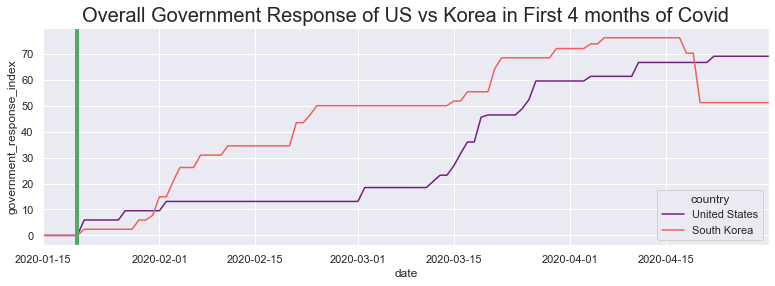

In [103]:
sns.set(rc={'figure.figsize':(13, 4)})
ax = sns.lineplot(data=df_govtrack, x="date", y="government_response_index", hue="country", palette="magma")
plt.title('Overall Government Response of US vs Korea in First 4 months of Covid', fontsize=20)
plt.xlim(pd.to_datetime('2020-01-15'), pd.to_datetime('2020-04-30'))

# Plot the "first day of contact"
ax.axvline(pd.to_datetime('2020-01-20'), color='g', lw=4, label="First");

Similarly, we can see that Korea responded a lot faster than the US in terms of enacting school closures or cancelling public events.

In [39]:
# Each of the c_xxxxx flags mentioned in the government response tracker
gov_flags = [re.search("c\d_[^flag]\w*", col).group() for col in df_govtrack.columns if re.match("c\d_[^flag]\w*", col)]
gov_flags.extend(["date", "response_since_first_infection", "country"])

# Get the containment and closure policies on each row for each flag
df_melt = df_govtrack[gov_flags].sort_values(by="date")\
    .melt(id_vars=["date", "response_since_first_infection", "country"])\
    .dropna()

display(df_melt.tail(3))

,date,response_since_first_infection,country,variable,value
1933,2020-04-29,100 days,South Korea,c8_international_travel_controls,3
1934,2020-04-30,101 days,United States,c8_international_travel_controls,3
1935,2020-04-30,101 days,South Korea,c8_international_travel_controls,3


We can see the relative responses for US vs. Korea

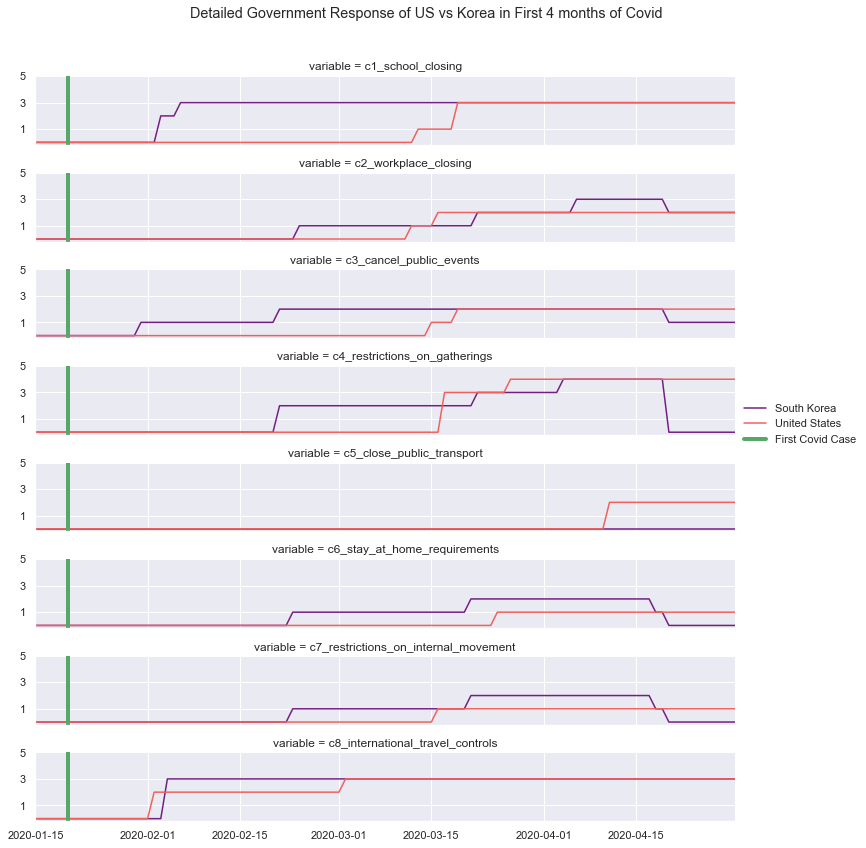

In [40]:
def add_line(**kwargs):
    plt.axvline(pd.to_datetime('2020-01-20'), lw=4, label="First Covid Case", **kwargs);

x_vars = "date"
y_vars = df_melt.variable.unique()

# Seaborn facetgrid for each variable
g = sns.FacetGrid(df_melt, col="variable", height=1.5, col_wrap=1, aspect=7)
# g.fig.subplots_adjust(wspace=5, hspace=5)
g.map_dataframe(sns.lineplot, x="date", y="value", hue="country", palette="magma") # Add lineplot for each government response
g.set_axis_labels("Date", "Response") # Add axis labels
g.set(xlim=(pd.to_datetime('2020-01-15'), pd.to_datetime('2020-04-30')), yticks=[1,3,5])
g.set_titles(col_template="{col_name}") # Format subplot titles

# Add spacing between graphs
plt.subplots_adjust(hspace=7.5)

# Add a line for the First Covid Case
g.map(add_line, color='g')

# Add legends and titles
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Detailed Government Response of US vs Korea in First 4 months of Covid');

By grouping by government response variable and country, we can see the "first" day that each country's government started implementing a response, and also when the level of that response changed (i.e. 3 is more stringent than 2). If we skim the following table, we can see that in general, South Korea seemed to respond a lot earlier than the US did. We can also see that most of the restrictions started lower (1 or 2) and jumped higher (3 or 4) within a few days.

In [41]:
df_melt[df_melt.value!=0].groupby(['variable', 'country', 'value']).first()

date  \
variable                             country       value              
c1_school_closing                    South Korea   2     2020-02-03   
                                                   3     2020-02-06   
                                     United States 1     2020-03-13   
                                                   3     2020-03-19   
c2_workplace_closing                 South Korea   1     2020-02-24   
                                                   2     2020-03-22   
                                                   3     2020-04-06   
                                     United States 1     2020-03-12   
                                                   2     2020-03-16   
c3_cancel_public_events              South Korea   1     2020-01-31   
                                                   2     2020-02-21   
                                     United States 1     2020-03-15   
                                                   2     2020-03-19   
c4_restrictions_on_gatherings        South Korea   2     2020-02-21   
                                                   3     2020-03-22   
                                                   4     2020-04-04   
                                     United States 3     2020-03-17   
                                                   4     2020-03-27   
c5_close_public_transport            United States 2     2020-04-11   
c6_stay_at_home_requirements         South Korea   1     2020-02-23   
                                                   2     2020-03-21   
                                     United States 1     2020-03-25   
c7_restrictions_on_internal_movement South Korea   1     2020-02-23   
                                                   2     2020-03-21   
                                     United States 1     2020-03-16   
c8_international_travel_controls     South Korea   3     2020-02-04   
                                     United States 2     2020-02-02   
                                                   3     2020-03-02   

                                                         response_since_first_infection  
variable                             country       value                                 
c1_school_closing                    South Korea   2                            14 days  
                                                   3                            17 days  
                                     United States 1                            53 days  
                                                   3                            59 days  
c2_workplace_closing                 South Korea   1                            35 days  
                                                   2                            62 days  
                                                   3                            77 days  
                                     United States 1                            52 days  
                                                   2                            56 days  
c3_cancel_public_events              South Korea   1                            11 days  
                                                   2                            32 days  
                                     United States 1                            55 days  
                                                   2                            59 days  
c4_restrictions_on_gatherings        South Korea   2                            32 days  
                                                   3                            62 days  
                                                   4                            75 days  
                                     United States 3                            57 days  
                                                   4                            67 days  
c5_close_public_transport            United States 2                            82 days  
c6_stay_at_home_requirements         South

Here, we are looking at the first response whatsoever (regardless of stringency leve) in each category. It becomes easier to see here that in general, Korea responded many days earlier than the US responded in almost all categories. the only exceptions are:
* closing public transport: Korea never (at least for the first few months of Covid) implemented public transport restriction measures. I can actually personally attest to this, as I was in Korea at the time, and the public transportation systems were running as normal
* international travel controls: This is the only measure that the US responded faster than Korea!

In [42]:
df_melt[df_melt.value!=0].groupby(['variable', 'country']).first().unstack()["response_since_first_infection"]

country,South Korea,United States
variable,,
c1_school_closing,14 days,53 days
c2_workplace_closing,35 days,52 days
c3_cancel_public_events,11 days,55 days
c4_restrictions_on_gatherings,32 days,57 days
c5_close_public_transport,NaT,82 days
c6_stay_at_home_requirements,34 days,65 days
c7_restrictions_on_internal_movement,34 days,56 days
c8_international_travel_controls,15 days,13 days


The same information as above can be viewed as a bar plot.

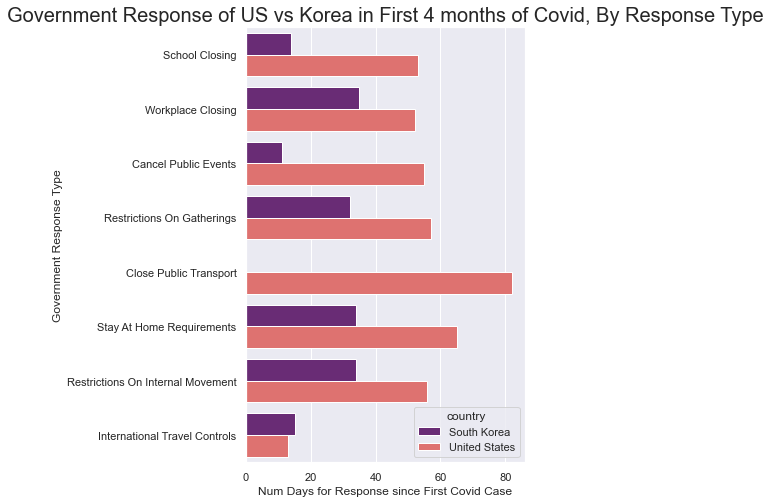

In [210]:
df_bar_data = df_melt[df_melt.value!=0].groupby(['variable', 'country']).first()\
    ["response_since_first_infection"].reset_index()

# Map days (datetime object) to integers
df_bar_data["response_since_first_infection"] = df_bar_data["response_since_first_infection"]\
    .apply(lambda a: a.days)

# Plot barplot
sns.set(rc={'figure.figsize':(5,8)})
g = sns.barplot(data=df_bar_data, y="variable", x="response_since_first_infection", 
                hue="country", palette="magma", orient='h', ci=False)

# Format the ticklabels to capitalize each word
g.set_yticklabels([' '.join([a.capitalize() for a in c.split('_')[1:]]) for c in df_melt.variable.unique()])

# Add labels and title
g.set_xlabel('Num Days for Response since First Covid Case')
g.set_ylabel('Government Response Type')
plt.title('Government Response of US vs Korea in First 4 months of Covid, By Response Type', fontsize=20);


We can see that, on average across all of the eight government response variables, the US took twice as long as Korea to respond!

In [435]:
df_melt[df_melt.value!=0].groupby(['variable', 'country']).first().unstack()\
    [["response_since_first_infection"]].mean().unstack(0)

,response_since_first_infection
country,
South Korea,25 days 00:00:00
United States,54 days 03:00:00


### Limitations and Future Work

In [ ]:
# South korea no public transport close
# US first international restriction

Limitations
* It is possible the data is not entirely accurate especially early on in the covid days
* Are limited in terms of "government response" nuance, because we don't know exaclty what KIND of response, and also, someone handlabeled these responses on a scale of 0 to 3 or 4... so, it doesn't say that much in terms of what kind of response, we only know general category of response
* 

Future Work
* Looking at more countries, not just these two
* Looking at the second half of the year, how the responses changed ... did they end up normalizing?

Conculsions
* US response to covid severely lagged behind Korea's - twice as much! While on average (across the eight different government measures) Korea responded within 25 days of the first covid case, US responded within an average of 54 days. Even better for comparison was the fact that both countries had the first COVID case on the same day.

# Part 2

### Literature Overview
As a continuation of Part 1, I wanted to examine government response time to "first case of Covid," but this time scaled to all countries. Different countries have had vastly different responses to Covid, and scholars have different theories about this. 

* What are good predictors for Covid response? https://ourworldindata.org/identify-covid-exemplars
* LSE saying that having more women leads to better covid response



The question I would like to answer in this part is: **Does the "regime type" of a government, as described by the Economist's Democracy Index, have an impact on a country's government response to enact restrictiosn in internal movements within the country?** That is, can a country's government (and the democracy level of that government) explain that country's willingness to impose stringent government controls?

* Ex: Philippines, China, really stringent approaches [cite]
* US really rolled their feet before having a lot of restrictions, and partially this is because a lot of Republicans are like freedom and shit [cite]
* This article argues that democracies responded better https://journals.sagepub.com/doi/full/10.1177/2319714520928884
* https://www.theatlantic.com/ideas/archive/2020/02/why-democracies-are-better-fighting-outbreaks/606976/ pro democracy
* lot of info here https://carnegieendowment.org/2020/03/31/do-authoritarian-or-democratic-countries-handle-pandemics-better-pub-81404 "Authoritarian and democratic governments both have mixed records when it comes to pandemic response"
* https://www.chathamhouse.org/2020/05/why-democracies-do-better-surviving-pandemics

I will be using the 2019democracy index calculated by the Economist Intelligence Unit (The Economist Intelligence Unit, 2019). I will have scraped it from Wikipedia, though. [cite... why? Is the EIU version different?]
* cite [this](https://www.semanticscholar.org/paper/Statistical-Classification-of-Democracy-Index-of-of-Bashar-Tsokos/c4df21e52c0225e0946321270d6bbc798f9f5924) and talk about some issues with democracy index




### Data Exploration

I'll be focusing on just the `c7_restrictions_on_internal_movements` flag. It can take the following values:
0 - no measures
1 - recommend not to travel between regions/cities
2 - internal movement restrictions in place
Blank - no data (Codebook)

I want to only look at restrictions at level "2" because they are stringent and 1 is just a recommendation

In [9]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [10]:
from bs4 import BeautifulSoup
import requests
import statsmodels.api as sm
import datetime as dt

In [11]:
# Getting democracy index from Wikipedia page
response = requests.get("https://en.wikipedia.org/wiki/Democracy_Index")
soup = BeautifulSoup(response.text)

countries, scores, regimetypes, regions = [], [], [], []

for line in soup.find_all("table")[2].find_all("tr")[1:]:
    country = line.find("a").text
    score, regimetype = [a.text for a in line.find_all("b")]
    
    table_items = [t.text for t in line.find_all("td")]
    table_items = [i for i in table_items if 'Score:' not in i]
    
    countries.append(country)
    scores.append(score)
    regimetypes.append(regimetype)
    regions.append(table_items[-1].strip('\n'))
        
    if country == "North Korea": break

In [12]:
dem_index = pd.DataFrame([countries, scores, regimetypes, regions]).T
dem_index.columns=["country", "dem_score", "regimetype", "region"]
dem_index.dem_score = dem_index.dem_score.apply(float)
display(dem_index.head())

,country,dem_score,regimetype,region
0,Norway,9.87,Full democracy,Western Europe
1,Iceland,9.58,Full democracy,Western Europe
2,Sweden,9.39,Full democracy,Western Europe
3,New Zealand,9.26,Full democracy,Asia & Australasia
4,Finland,9.25,Full democracy,Western Europe


In [13]:
# Load government tracking data from OX COVID
sql_command_all = """SELECT * FROM government_response\
    WHERE date < '2020-04-01'\
    ORDER by date ASC"""
df_govtrack_all = pd.read_sql(sql_command_all, conn)

# to datetime
df_govtrack_all.date = pd.to_datetime(df_govtrack_all['date'])
df_govtrack_all.government_response_index = df_govtrack_all.government_response_index.apply(float)

In [14]:
# Load epidemiology data from OX COVID
sql_command_epi = """SELECT * FROM epidemiology WHERE date < '2020-04-01' ORDER by date DESC"""
df_epidemiology = pd.read_sql(sql_command_epi, conn)

# to datetime
df_epidemiology.date = pd.to_datetime(df_epidemiology['date'])

In [15]:
# Determine "first case of covid" for each country
first_confirmed = df_epidemiology[df_epidemiology.confirmed>0]\
    .sort_values(by="date")[["country", "date", "confirmed", "gid"]]\
    .groupby("country").first()

# Extract GIDs from arrays
first_confirmed.gid = first_confirmed.gid.dropna().apply(lambda x: x[0])

# Drop rows with null GIDs. These are contienents (Africa, America, etc)
first_confirmed = first_confirmed[~first_confirmed.gid.isna()]

# Some GIDs are have extra numbers after it, get rid of them
first_confirmed.gid = first_confirmed.gid.apply(lambda x: re.search("(\w\w\w)",x).group(1))

In [16]:
# Selecting only "Restrictions on internal movement" government flag
gov_flags = ['c7_restrictions_on_internal_movement']
gov_flags.extend(["date", "country", "gid"])

# Dataframe with all of the government flags from above, melted
df_melt_all = df_govtrack_all[gov_flags]\
    .sort_values(by="date")\
    .melt(id_vars=["date", "country", "gid"])\
    .dropna()

# Merge in first confirmed date for each country
df_melt_all = df_melt_all.merge(first_confirmed, how="left", on=["gid"])\
    .rename(columns={"date_x": "date", "date_y": "first_confirmed_date"})\
    .drop(columns="confirmed")

# Calculate the number of days for each 
df_melt_all["response_since_first_infection"] = df_melt_all["date"] - df_melt_all["first_confirmed_date"]

In [17]:
df_melt_all[df_melt_all.value > 0].head(3)

,date,country,gid,variable,value,first_confirmed_date,response_since_first_infection
4592,2020-01-23,China,CHN,c7_restrictions_on_internal_movement,2.0,2019-12-31,23 days
4679,2020-01-24,China,CHN,c7_restrictions_on_internal_movement,2.0,2019-12-31,24 days
4906,2020-01-25,China,CHN,c7_restrictions_on_internal_movement,2.0,2019-12-31,25 days


As an aside, the following countries do not exist in the OxCovid database


**TO DO** dig into data and see why they do not exist.

In [18]:
df_melt_all[df_melt_all.first_confirmed_date.isna()].country.unique()

array(['Falkland Islands', 'Malawi', 'Vanuatu', 'Lesotho',
       'Solomon Islands', 'Tajikistan', 'Yemen', 'Turkmenistan',
       'Hong Kong', 'Macao', 'South Sudan', 'Pitcairn Islands'],
      dtype=object)

In [19]:
# FYI: Leaving in NAs because then the average will be more accurate

In [20]:
# Only looking at values that are above a 0 in score. 1=Recommended, 2=Restricted
df_all_countries= df_melt_all[df_melt_all.value>1].groupby(['variable', 'country']).first()\
    .unstack()[["response_since_first_infection"]]\
    .mean().unstack(0)

# Extract just the number of "days" from the time detla
df_all_countries["response_since_first_infection"] = df_all_countries["response_since_first_infection"]\
    .apply(lambda a: a.days)

# Drop the countries with no data about confirmed cases
df_all_countries = df_all_countries[~df_all_countries["response_since_first_infection"].isna()]
df_all_countries.reset_index(inplace=True)

# Merge back in the date of the first case of covid
df_all_countries = df_all_countries.merge(first_confirmed.reset_index()[["country", "gid", "date"]], on="country")\
    .rename(columns={"date": "first_case"})

We can see that some countries, like Mongolia, responded with strict internal movement restrictions **18 days** before their first Covid case! On the other end of the spectrum, Mexico responded with Level 2 stringent restrictions on internal movement 76 days after their first case.

Another thing to note here is that countries with "faster" response tend to have a later first Covid case (mid to late March), whereas those with "slower" response tend to have an earlier first Covid case (mid to late January)

In [21]:
print("Countries with fastest responses")
display(df_all_countries.sort_values(by='response_since_first_infection').head(10))

print("Countries with slowest responses")
display(df_all_countries.sort_values(by='response_since_first_infection').tail(10))

Countries with fastest responses


,country,response_since_first_infection,gid,first_case
74,Mongolia,-18.0,MNG,2020-03-10
48,Guatemala,-8.0,GTM,2020-03-14
66,Libya,-2.0,LBY,2020-03-24
91,Puerto Rico,-2.0,PRI,2020-03-14
50,Haiti,-1.0,HTI,2020-03-20
37,El Salvador,-1.0,SLV,2020-03-19
117,Venezuela,-1.0,VEN,2020-03-14
47,Greenland,0.0,GRL,2020-03-18
62,Kosovo,0.0,RKS,2020-03-13
20,Cape Verde,0.0,CPV,2020-03-20


Countries with slowest responses


,country,response_since_first_infection,gid,first_case
69,Malaysia,53.0,MYS,2020-01-25
5,Australia,54.0,AUS,2020-01-25
19,Canada,54.0,CAN,2020-01-26
114,United Arab Emirates,56.0,ARE,2020-01-27
41,Finland,58.0,FIN,2020-01-29
77,Nepal,59.0,NPL,2020-01-23
102,South Korea,62.0,KOR,2020-01-19
115,United Kingdom,72.0,GBR,2020-01-11
107,Thailand,74.0,THA,2020-01-12
72,Mexico,76.0,MEX,2020-01-14


In [22]:
# Merge in democracy score
df_merge = df_all_countries.merge(dem_index, on="country")

display(df_merge.head())

,country,response_since_first_infection,gid,first_case,dem_score,regimetype,region
0,Albania,4.0,ALB,2020-03-09,5.89,Hybrid regime,Eastern Europe
1,Algeria,27.0,DZA,2020-02-25,4.01,Hybrid regime,Middle East & North Africa
2,Angola,7.0,AGO,2020-03-20,3.72,Authoritarian,Sub-Saharan Africa
3,Argentina,22.0,ARG,2020-02-27,7.02,Flawed democracy,Latin America
4,Australia,54.0,AUS,2020-01-25,9.09,Full democracy,Asia & Australasia


If we group solely by regime type, the data seem to be telling us something interesting. More authoritarian governments tend to respond faster than democractic governments. On one hand, this makes sense with the literature - more authoritarian governments are likely to enact more stringent measures, and more liberal governments are likely to care more about citizens' privacy and freedom. But is it entirely true to say that authoritarian governments tended to act quicker than democractic governments?

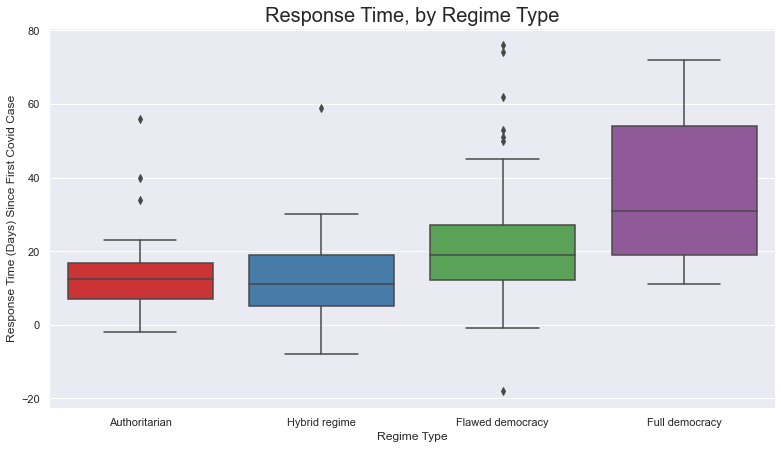

In [93]:
a4_dims = (13, 7)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.boxplot(ax=ax, x="regimetype", y="response_since_first_infection", 
                order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge, palette="Set1")
plt.xlabel('Regime Type')
plt.ylabel('Response Time (Days) Since First Covid Case')
plt.title('Response Time, by Regime Type', fontsize=20);

However, if we plot the four regime types' response times by looking at their First Covid Case, we can get more granular over time.

In [24]:
# Adding extra categories for analysis purposes
df_merge['first_case_woy'] = df_merge.first_case.dt.isocalendar().week # week of year
df_merge['first_case_biweekly'] = df_merge.first_case_woy//2           # every two weeks 
df_merge['first_case_month'] = df_merge.first_case.dt.month            # month

# Ordinal
df_merge['first_case_ordinal'] = pd.to_datetime(df_merge['first_case']).apply(lambda date: date.toordinal())

<ipython-input-94-741bc182ae06>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels);


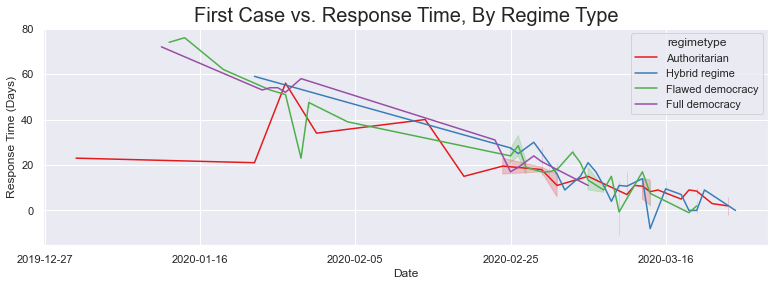

In [94]:
sns.set(rc={'figure.figsize':(13, 4)})
ax = sns.lineplot(data=df_merge, x="first_case_ordinal", y="response_since_first_infection", 
                  hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                  hue="regimetype", palette="Set1")
plt.title('First Case vs. Response Time, By Regime Type', fontsize=20);

ax.set_xlabel('Date')
ax.set_ylabel('Response Time (Days)')
new_labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels);

If we go back to the countries with fastest/slowest response above, we can see that, in general, countries with later first cases tended to respond faster after their first case. We can also see that democracy index does not seem to have as much of an impact on determining how fast a country will respond to Covid, and that perhaps the date of the First Covid Case is more influential.

However, we do see outliers. The purple dot right before `2020-01-01` is China, and they responded relatively fast. There are a few other countries that responded fast despite a relatively lower democracy score.


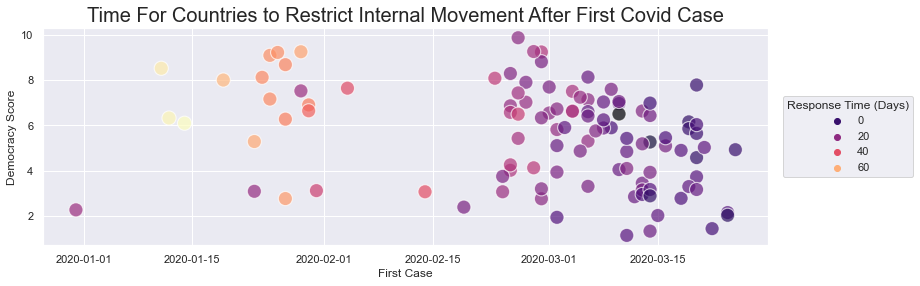

In [81]:
sns.set(rc={'figure.figsize':(13, 4)})

g = sns.scatterplot(data=df_merge, x="first_case", y="dem_score", 
                hue="response_since_first_infection", s=200, alpha=.7, palette="magma")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center right', borderaxespad=0.)

plt.xlabel('First Case')
plt.ylabel('Democracy Score')

leg = g.axes.get_legend()
leg.set_title("Response Time (Days)")
plt.title("Time For Countries to Restrict Internal Movement After First Covid Case", fontsize=20);


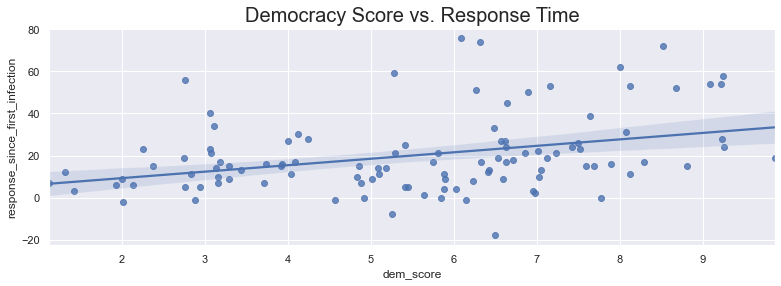

In [27]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.regplot(x="dem_score", y="response_since_first_infection", data=df_merge)
plt.title('Democracy Score vs. Response Time', fontsize=20);

In [28]:
y = df_merge["response_since_first_infection"]
X = df_merge["dem_score"]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     response_since_first_infection   R-squared:                       0.127
Model:                                        OLS   Adj. R-squared:                  0.118
Method:                             Least Squares   F-statistic:                     15.37
Date:                            Mon, 23 Nov 2020   Prob (F-statistic):           0.000157
Time:                                    14:34:22   Log-Likelihood:                -459.10
No. Observations:                             108   AIC:                             922.2
Df Residuals:                                 106   BIC:                             927.6
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

Doing the same as above, but setting the First Covid Case as the independent variable

<ipython-input-29-a5e739190012>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels);


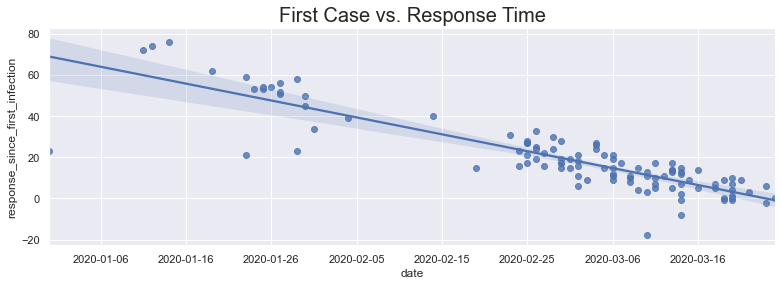

In [29]:
sns.set(rc={'figure.figsize':(13, 4)})
ax = sns.regplot(x="first_case_ordinal", y="response_since_first_infection", data=df_merge)
plt.title('First Case vs. Response Time', fontsize=20);

ax.set_xlabel('date')
ax.set_label('Response Time (Days)')
new_labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels);

In [30]:
y = df_merge["response_since_first_infection"]
X = df_merge["first_case_ordinal"]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     response_since_first_infection   R-squared:                       0.764
Model:                                        OLS   Adj. R-squared:                  0.761
Method:                             Least Squares   F-statistic:                     342.6
Date:                            Mon, 23 Nov 2020   Prob (F-statistic):           5.49e-35
Time:                                    14:34:23   Log-Likelihood:                -388.50
No. Observations:                             108   AIC:                             781.0
Df Residuals:                                 106   BIC:                             786.4
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---

Here we can see the following laid out in one chart:

|   | Dem Index v Response Time  | First Case v Response Time   |  
|---|---|---|
| R square  |  0.132 | 0.759 |
| Standard error | 0.804 | 0.046 |


For the first case (Democracy Index vs Response Time), the R-squared value was fairly low and the standard error was fairly high. For the second case (First Case vs Response Time), the R-squared value was fairly high and the standard error was fairly low. This seems to indicate that perhaps there is more influence of First Case rather than Democracy Index upon the Response Time

Another way to look at the data is by grouping by both the First Covid Case and the Regime Type

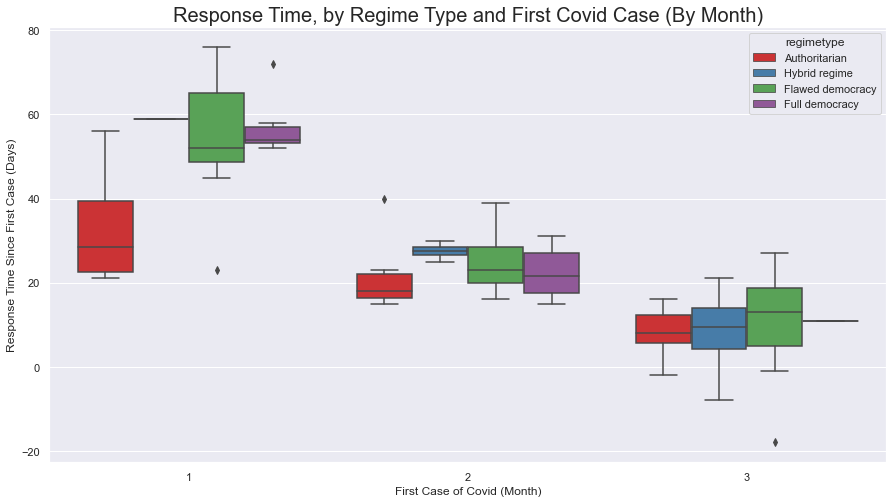

In [95]:
# Special case: China's first case was december 31, 2019 ... so we are going to temporarily
# move it to january just to make the box plot easier to interpret
df_merge_months = df_merge.copy()
df_merge_months.loc[df_merge_months.country=="China", "first_case_month"] = 1

a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(ax=ax, x="first_case_month", y="response_since_first_infection", hue="regimetype", 
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge_months, palette="Set1")
plt.xlabel('First Case of Covid (Month)')
plt.ylabel('Response Time Since First Case (Days)')
plt.title('Response Time, by Regime Type and First Covid Case (By Month)', fontsize=20);

Once we do two-week splices, it becomes a little more evident that First Covid Case seems to have a bigger impact on Response Time. However, the influence of Regime Type is not negligble. 

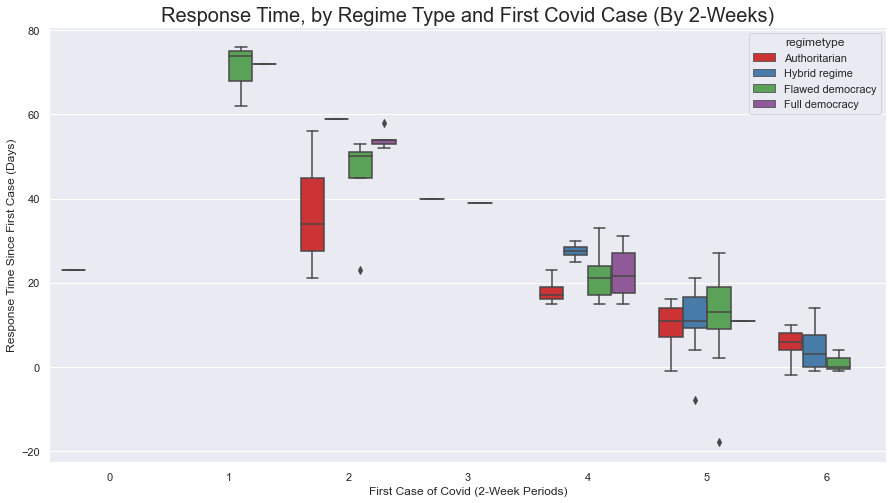

In [96]:
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(ax=ax, x="first_case_biweekly", y="response_since_first_infection", hue="regimetype", 
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge, palette="Set1")
plt.xlabel('First Case of Covid (2-Week Periods)')
plt.ylabel('Response Time Since First Case (Days)')
plt.title('Response Time, by Regime Type and First Covid Case (By 2-Weeks)', fontsize=20);

Once we split into week-long segments, we can see that in the first seven or so weeks of the year, there is a lot of noise, but the things cluster together

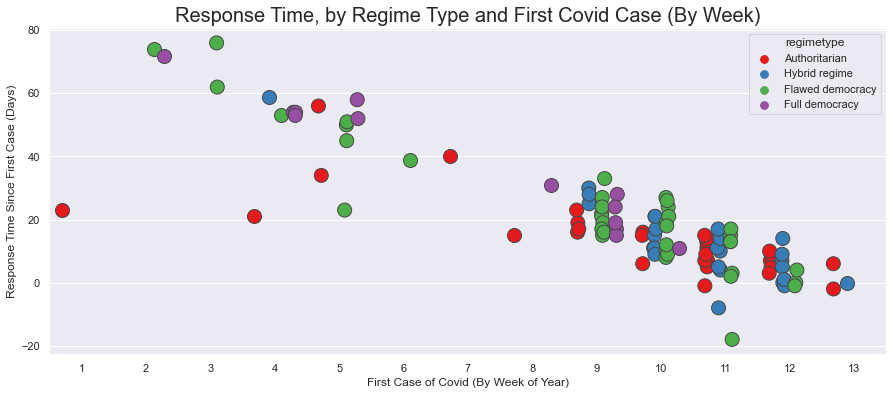

In [99]:
sns.set(rc={'figure.figsize':(15, 6)})

sns.stripplot(x="first_case_woy", y="response_since_first_infection", hue="regimetype", dodge=True, 
                zorder=1, size=14, linewidth=1,
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge_months, palette="Set1")
plt.xlabel('First Case of Covid (By Week of Year)')
plt.ylabel('Response Time Since First Case (Days)')
plt.title('Response Time, by Regime Type and First Covid Case (By Week)', fontsize=20);

Another way to view this same data is using a barplot.

In [45]:
# this is less useful, maybe get rid of it

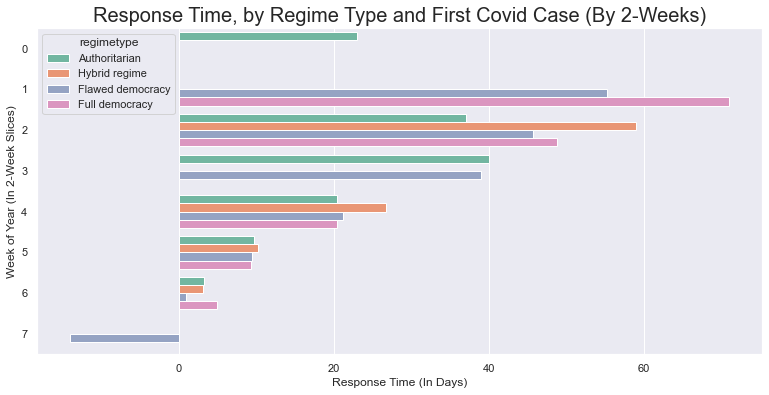

In [46]:
sns.set(rc={'figure.figsize':(13, 6)})
g = sns.barplot(data=df_merge, y="first_case_biweekly", x="response_since_first_infection", 
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                hue="regimetype", palette="Set2", orient='h', ci=False)

plt.ylabel('Week of Year (In 2-Week Slices)')
plt.xlabel('Response Time (In Days)')
plt.title('Response Time, by Regime Type and First Covid Case (By 2-Weeks)', fontsize=20);

In [211]:
df_merge

,country,response_since_first_infection,gid,first_case,dem_score,regimetype,region,first_case_woy,first_case_biweekly,first_case_month,first_case_ordinal
0,Albania,4.0,ALB,2020-03-09,5.89,Hybrid regime,Eastern Europe,11,5,3,737493
1,Algeria,27.0,DZA,2020-02-25,4.01,Hybrid regime,Middle East & North Africa,9,4,2,737480
2,Angola,7.0,AGO,2020-03-20,3.72,Authoritarian,Sub-Saharan Africa,12,6,3,737504
3,Argentina,22.0,ARG,2020-02-27,7.02,Flawed democracy,Latin America,9,4,2,737482
4,Australia,54.0,AUS,2020-01-25,9.09,Full democracy,Asia & Australasia,4,2,1,737449
...,...,...,...,...,...,...,...,...,...,...,...
103,United Kingdom,72.0,GBR,2020-01-11,8.52,Full democracy,Western Europe,2,1,1,737435
104,Uzbekistan,9.0,UZB,2020-03-15,2.01,Authoritarian,Eastern Europe,11,5,3,737499
105,Venezuela,-1.0,VEN,2020-03-14,2.88,Authoritarian,Latin America,11,5,3,737498
106,Vietnam,21.0,VNM,2020-01-23,3.08,Authoritarian,Asia & Australasia,4,2,1,737447


In [303]:
df_merge = df_merge.merge(world_pop_2019[["country_code", "population"]], 
                          left_on="gid", right_on="country_code")
df_merge = df_merge.drop(columns=["country_code"])

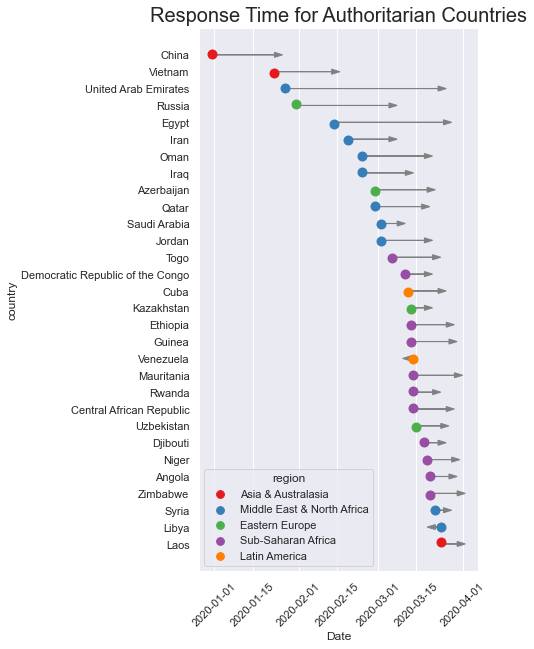

In [315]:
# https://nikkimarinsek.com/blog/how-to-make-an-arrow-plot

data = df_merge[df_merge.regimetype=="Authoritarian"].sort_values(by="first_case").reset_index()
ax = plt.figure(figsize=(5,10))

#add start points
ax = sns.stripplot(data=data, 
                   x='first_case', 
                   y='country', 
                   orient='h', 
                   hue='region',
#                    size="population",
                   size=10,
                   palette='Set1')
arrow_starts = data['first_case'].values
arrow_lengths = data['response_since_first_infection']

#add arrows to plot
for i, subject in enumerate(data['country']):
    ax.arrow(arrow_starts[i],        #x start point
             i,                      #y start point
             arrow_lengths[i],       #change in x 
             0,                      #change in y
             head_width=.3,         #arrow head width
             head_length=3,        #arrow head length
             width=0.01,              #arrow stem width
             fc='gray',             #arrow fill color
             ec='gray')             #arrow edge color

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title('Response Time for Authoritarian Countries', fontsize=20);

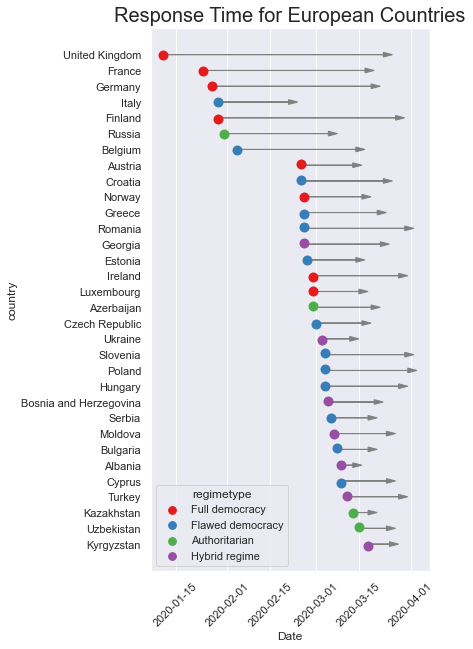

In [320]:
# https://nikkimarinsek.com/blog/how-to-make-an-arrow-plot

data = df_merge[df_merge.region.str.contains("Europe")].sort_values(by="first_case").reset_index()
ax = plt.figure(figsize=(5,10))

#add start points
ax = sns.stripplot(data=data, 
                   x='first_case', 
                   y='country', 
                   orient='h', 
                   hue='regimetype',
#                    size="population",
                   size=10,
                   palette='Set1')
arrow_starts = data['first_case'].values
arrow_lengths = data['response_since_first_infection']

#add arrows to plot
for i, subject in enumerate(data['country']):
    ax.arrow(arrow_starts[i],        #x start point
             i,                      #y start point
             arrow_lengths[i],       #change in x 
             0,                      #change in y
             head_width=.3,         #arrow head width
             head_length=3,        #arrow head length
             width=0.01,              #arrow stem width
             fc='gray',             #arrow fill color
             ec='gray')             #arrow edge color

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title('Response Time for European Countries', fontsize=20);

In [332]:
df_merge

,country,response_since_first_infection,gid,first_case,dem_score,regimetype,region,first_case_woy,first_case_biweekly,first_case_month,first_case_ordinal,population
0,Albania,4.0,ALB,2020-03-09,5.89,Hybrid regime,Eastern Europe,11,5,3,737493,2854191
1,Algeria,27.0,DZA,2020-02-25,4.01,Hybrid regime,Middle East & North Africa,9,4,2,737480,43053054
2,Angola,7.0,AGO,2020-03-20,3.72,Authoritarian,Sub-Saharan Africa,12,6,3,737504,31825295
3,Argentina,22.0,ARG,2020-02-27,7.02,Flawed democracy,Latin America,9,4,2,737482,44938712
4,Australia,54.0,AUS,2020-01-25,9.09,Full democracy,Asia & Australasia,4,2,1,737449,25364307
...,...,...,...,...,...,...,...,...,...,...,...,...
103,United Kingdom,72.0,GBR,2020-01-11,8.52,Full democracy,Western Europe,2,1,1,737435,66834405
104,Uzbekistan,9.0,UZB,2020-03-15,2.01,Authoritarian,Eastern Europe,11,5,3,737499,33580650
105,Venezuela,-1.0,VEN,2020-03-14,2.88,Authoritarian,Latin America,11,5,3,737498,28515829
106,Vietnam,21.0,VNM,2020-01-23,3.08,Authoritarian,Asia & Australasia,4,2,1,737447,96462106


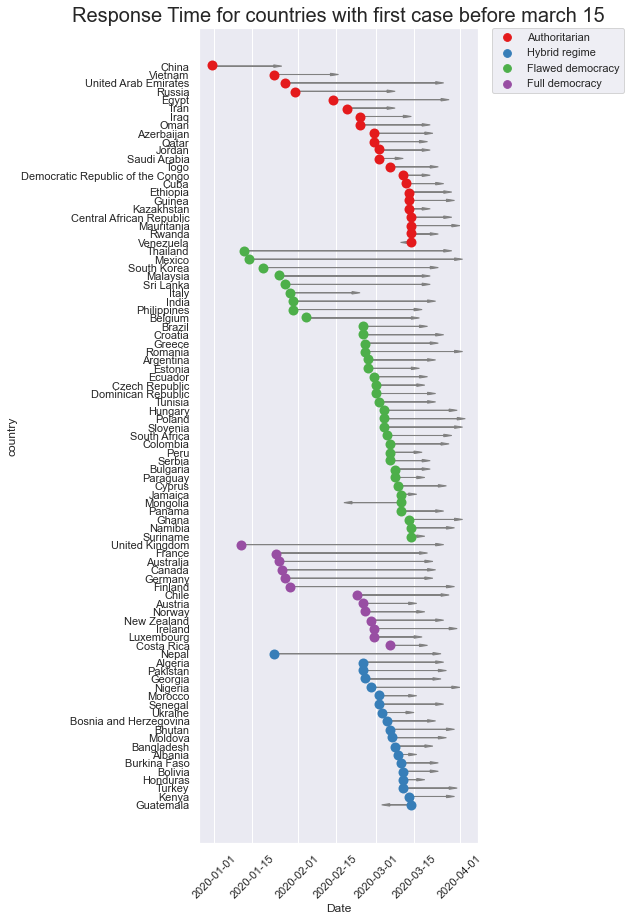

In [340]:
# https://nikkimarinsek.com/blog/how-to-make-an-arrow-plot

data = df_merge[df_merge.first_case < datetime(2020,3,15)].sort_values(by=["regimetype", "first_case"]).reset_index()
ax = plt.figure(figsize=(5,15))

#add start points
ax = sns.stripplot(data=data, 
                   x='first_case', 
                   y='country', 
                   orient='h', 
                   hue='regimetype',
                   hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                   size=10,
                   palette='Set1')
arrow_starts = data['first_case'].values
arrow_lengths = data['response_since_first_infection']

#add arrows to plot
for i, subject in enumerate(data['country']):
    ax.arrow(arrow_starts[i],        #x start point
             i,                      #y start point
             arrow_lengths[i],       #change in x 
             0,                      #change in y
             head_width=.3,         #arrow head width
             head_length=3,        #arrow head length
             width=0.01,              #arrow stem width
             fc='gray',             #arrow fill color
             ec='gray')             #arrow edge color

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title('Response Time for countries with first case before march 15', fontsize=20);

In [ ]:
# From this above chart. you tend to have shorter arrows if your first date was later.
# You tend to have shorter arrows if you are authoritarian
# But there are outlier
# authoritarians that took long time like uae
# dem that did fast, like italy

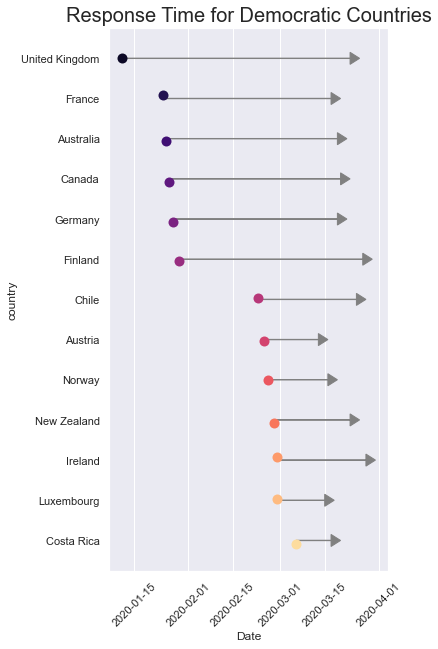

In [290]:
# https://nikkimarinsek.com/blog/how-to-make-an-arrow-plot

data = df_merge[df_merge.regimetype=="Full democracy"].sort_values(by="first_case").reset_index()
ax = plt.figure(figsize=(5,10))

#add start points
ax = sns.stripplot(data=data, 
                   x='first_case', 
                   y='country', 
                   orient='h', 
                   size=10,
                   palette='magma')
arrow_starts = data['first_case'].values
arrow_lengths = data['response_since_first_infection']

#add arrows to plot
for i, subject in enumerate(data['country']):
    ax.arrow(arrow_starts[i],        #x start point
             i,                      #y start point
             arrow_lengths[i],       #change in x 
             0,                      #change in y
             head_width=.3,         #arrow head width
             head_length=3,        #arrow head length
             width=0.01,              #arrow stem width
             fc='gray',             #arrow fill color
             ec='gray')             #arrow edge color

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title('Response Time for Democratic Countries', fontsize=20);

In [ ]:
# Idea: How do countries feel in response to covid response of their government
# Idea: How do people feel in response to covid restrictions
# IdeA: https://github.com/YouGov-Data/covid-19-tracker
# which is from https://chartserver.live/server/yg/v4/covid_charts_embed.php?c_id=2
# or this https://www.edelman.com/trustbarometer
# but i prefer the first one

In [68]:
page=1
url = f"http://api.worldbank.org/v2/country/all/indicator/GE.EST?date=2019&format=json&page={page}"
# Government Effectiveness captures perceptions of the quality of public services, 
# the quality of the civil service and the degree of its independence from political pressures, 
# the quality of policy formulation and implementation, and the credibility of the government's 
# commitment to such policies. Estimate gives the country's score on the aggregate indicator, 
# in units of a standard normal distribution, i.e. ranging from approximately -2.5 to 2.5.

In [69]:
response = requests.get(url)

In [70]:
response.json()

[{'page': 1,
  'pages': 5,
  'per_page': 50,
  'total': 214,
  'sourceid': '3',
  'lastupdated': '2020-09-28'},
 [{'indicator': {'id': 'GE.EST',
    'value': 'Government Effectiveness: Estimate'},
   'country': {'id': 'AF', 'value': 'Afghanistan'},
   'countryiso3code': 'AFG',
   'date': '2019',
   'value': -1.463875,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'GE.EST',
    'value': 'Government Effectiveness: Estimate'},
   'country': {'id': 'AL', 'value': 'Albania'},
   'countryiso3code': 'ALB',
   'date': '2019',
   'value': -0.0613309,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'GE.EST',
    'value': 'Government Effectiveness: Estimate'},
   'country': {'id': 'DZ', 'value': 'Algeria'},
   'countryiso3code': 'DZA',
   'date': '2019',
   'value': -0.5161746,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'GE.EST',
    'value': 'Government Effectiveness: Estimate'},
   'country': {'id': 'A

In [62]:
soup = BeautifulSoup(response.text, 'lxml')

In [64]:
soup

<html><body><p>ï»¿<?xml version="1.0" encoding="utf-8"?>
<wb:indicators page="1" pages="1" per_page="50" total="36" xmlns:wb="http://www.worldbank.org">
<wb:indicator id="CC.EST">
<wb:name>Control of Corruption: Estimate</wb:name>
<wb:unit></wb:unit>
<wb:source id="3">Worldwide Governance Indicators</wb:source>
<wb:sourcenote>Control of Corruption captures perceptions of the extent to which public power is exercised for private gain, including both petty and grand forms of corruption, as well as "capture" of the state by elites and private interests. Estimate gives the country's score on the aggregate indicator, in units of a standard normal distribution, i.e. ranging from approximately -2.5 to 2.5.</wb:sourcenote>
<wb:sourceorganization>Detailed documentation of the WGI, interactive tools for exploring the data, and full access to the underlying source data available at www.govindicators.org.The WGI are produced by Daniel Kaufmann (Natural Resource Governance Institute and Brookings I

In [77]:
oecd = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.TRUSTGOV.TOT.PC.A/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=2018")

In [78]:
oecd

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,TRUSTGOV,TOT,PC,A,2018,45.7,NaN
1,AUT,TRUSTGOV,TOT,PC,A,2018,45.3,NaN
2,BEL,TRUSTGOV,TOT,PC,A,2018,43.7,NaN
3,CAN,TRUSTGOV,TOT,PC,A,2018,62.7,NaN
4,CZE,TRUSTGOV,TOT,PC,A,2018,39.3,NaN
5,DNK,TRUSTGOV,TOT,PC,A,2018,55.7,NaN
6,FIN,TRUSTGOV,TOT,PC,A,2018,55.0,NaN
7,FRA,TRUSTGOV,TOT,PC,A,2018,34.3,NaN
8,DEU,TRUSTGOV,TOT,PC,A,2018,58.7,NaN
9,GRC,TRUSTGOV,TOT,PC,A,2018,14.3,NaN


In [791]:
# World Bank API to merge in size of each country (population)
# Do smaller countries 

In [300]:
country_codes, countries, populations = [], [], []

for page in range(1,7):
    url = f"http://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?date=2019&format=json&page={page}"
    response = requests.get(url)
    for r in response.json():
        if "page" in r:
            continue
        for l in r:
            country_codes.append(l["countryiso3code"])
            countries.append(l["country"]["value"])
            populations.append(l["value"])

world_pop_2019 = pd.DataFrame([countries, country_codes, populations]).T
world_pop_2019.columns = ["country", "country_code", "population"]

In [301]:
world_pop_2019[world_pop_2019.population.isna()]

,country,country_code,population
33,Not classified,,None
108,Eritrea,ERI,None


In [302]:
# drop null (the only null country was Eritrea) and map int to population
world_pop_2019 = world_pop_2019[~world_pop_2019.population.isna()]
world_pop_2019.population = world_pop_2019.population.apply(int)
world_pop_2019.head()

,country,country_code,population
0,Arab World,ARB,427870270
1,Caribbean small states,CSS,7401381
2,Central Europe and the Baltics,CEB,102378579
3,Early-demographic dividend,EAR,3290290622
4,East Asia & Pacific,EAS,2340628292


In [795]:
# merge in the population
df_merge = df_merge.merge(world_pop_2019[["country_code", "population"]], 
                          left_on="gid", right_on="country_code")
df_merge = df_merge.drop(columns=["country_code"])

In [798]:
df_merge.head()

,country,response_since_first_infection,gid,first_case,dem_score,regimetype,region,first_case_woy,first_case_biweekly,first_case_month,first_case_ordinal,population
0,Albania,4.0,ALB,2020-03-09,5.89,Hybrid regime,Eastern Europe,11,5,3,737493,2854191
1,Algeria,27.0,DZA,2020-02-25,4.01,Hybrid regime,Middle East & North Africa,9,4,2,737480,43053054
2,Angola,7.0,AGO,2020-03-20,3.72,Authoritarian,Sub-Saharan Africa,12,6,3,737504,31825295
3,Argentina,22.0,ARG,2020-02-27,7.02,Flawed democracy,Latin America,9,4,2,737482,44938712
4,Australia,54.0,AUS,2020-01-25,9.09,Full democracy,Asia & Australasia,4,2,1,737449,25364307


In [797]:
# TO DO population LOG

[None]

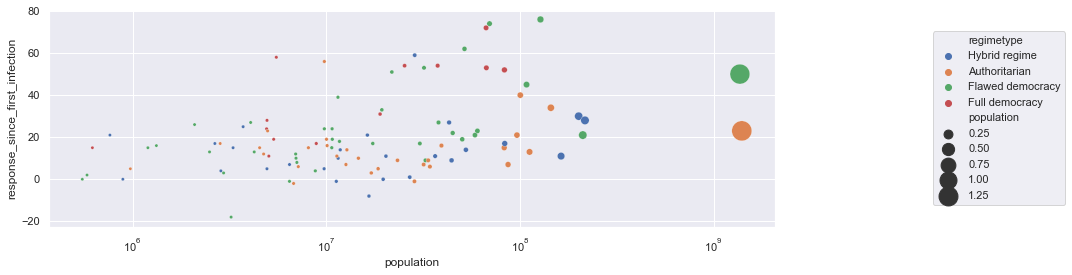

In [841]:
sns.set(rc={'figure.figsize':(13, 4)})
ax = sns.scatterplot(x="population", y="response_since_first_infection", sizes=(10,400),
                     size="population", hue="regimetype", data=df_merge)
plt.legend(bbox_to_anchor=(1.4, 0.5), loc='center right', borderaxespad=0.)

ax.set(xscale="log")
# plt.title('First Case vs. Response Time', fontsize=20);

# ax.set_xlabel('Date')
# new_labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
# ax.set_xticklabels(new_labels);

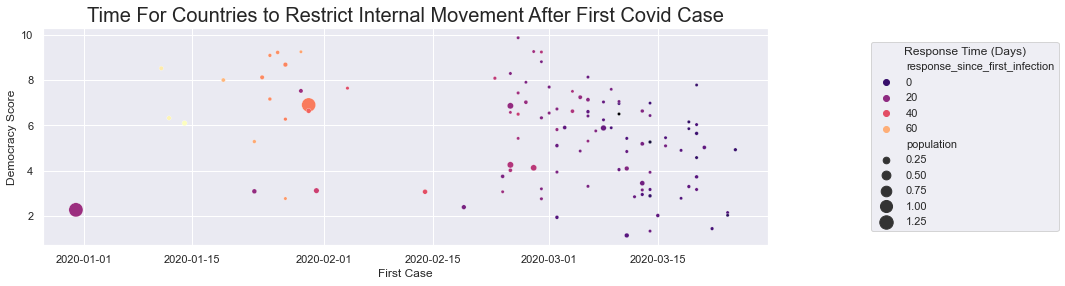

In [838]:
sns.set(rc={'figure.figsize':(13, 4)})

g = sns.scatterplot(data=df_merge, x="first_case", y="dem_score", size="population", sizes=(10,200),
                hue="response_since_first_infection", s=80, palette="magma", legend="brief")
plt.legend(bbox_to_anchor=(1.4, 0.5), loc='center right', borderaxespad=0.)

plt.xlabel('First Case')
plt.ylabel('Democracy Score')

leg = g.axes.get_legend()
leg.set_title("Response Time (Days)")
plt.title("Time For Countries to Restrict Internal Movement After First Covid Case", fontsize=20);


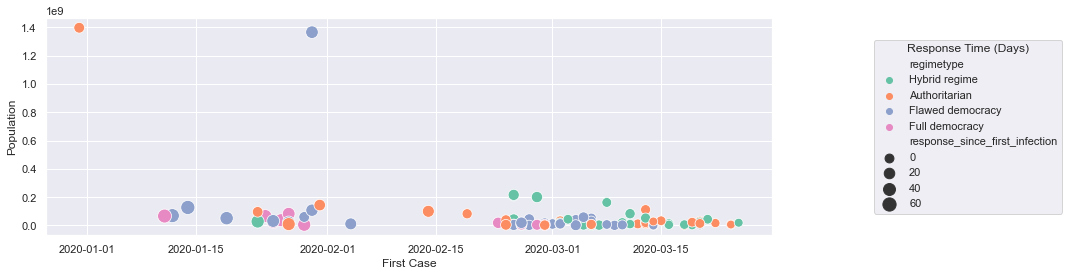

In [849]:
sns.set(rc={'figure.figsize':(13, 4)})

g = sns.scatterplot(data=df_merge, x="first_case", y="population", size="response_since_first_infection", 
                sizes=(50,200), hue="regimetype", s=80, palette="Set2", legend="brief")
plt.legend(bbox_to_anchor=(1.4, 0.5), loc='center right', borderaxespad=0.)

plt.xlabel('First Case')
plt.ylabel('Population')

ax.set(yscale="log")


leg = g.axes.get_legend()
leg.set_title("Response Time (Days)")
# plt.title("Time For Countries to Restrict Internal Movement After First Covid Case", fontsize=20);


Conclusion:

* At first glance, it seemed like authoritarian countries responded faster than democratic countries. It seemed like  authoritarian countries (or, countries with low "democratic index" scores), responded quicker to Covid by enacting strict rules about internal movements. In some cases, it seemed like authoritarian countries were responding even BEFORE they had their first case. 
* However, once we divide up by period of First Covid Case, we can see that in fact, many of the authoritarian countries tended to have their first case later. It seems that with the original hypothesis, First Covid Case was a confounder
* We should recognize that a lot of small countries we might not expect to have responded fast, did so in fact
* On the other hand, we should not make broad claims or conclusions that authoritarian countries necessarily lead to faster response. In fact, the First Covid Case, as we have seen, seemed to have a larger impact.



Limitations:
* Of the Democracy Index
* Of OxCovid Database, Government Indicator project, and its accuracy ...
* Authoritarian governments may not publish their first date of covid might be wrong

# FUTURE WORK

Doing more of a rigorous statistical analysis 

# Works Cited

Codebook for the Oxford Covid-19 Government Response Tracker (2020). GitHub Repository. Retrieved November 18, 2020 from https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md.

Florida Atlantic University. (2020, August 20). COVID-19: How South Korea prevailed while the United States failed. ScienceDaily. Retrieved November 13, 2020 from www.sciencedaily.com/releases/2020/08/200820102431.htm.

Holshue, M.L., DeBolt, C., Lindquist, S., Lofy, K.H., Wiesman, J., Bruce, H., Spitters, C.L., Ericson, K., Wilkerson, S., Tural, A., Díaz, G.T., Cohn, A., Fox, L., Patel, A., Gerber, S., Kim, L., Tong, S., Lu, X., Lindstrom, S., Pallansch, M., Weldon, W., Biggs, H., Uyeki, T.M., & Pillai, S. (2020). First Case of 2019 Novel Coronavirus in the United States. The New England Journal of Medicine, 382, 929 - 936.

Lim, J., Jeon, S., Shin, H.Y., Kim, M.J., Seong, Y.M., Lee, W.J., Choe, K.W., Kang, Y.M., Lee, B., & Park, S.J. (2020). Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR. Journal of Korean Medical Science, 35.

Mahdi, A., Blaszczyk, P., Dlotko, P., Salvi, D., Chan, T., Harvey, J., Gurnari, D., Wu, Y., Farhat, A., Hellmer, N., Zarebski, A., Hogan, B., & Tarassenko, L. (2020). OxCOVID19 Database: a multimodal data repository for better understanding the global impact of COVID-19. medRxiv.

The Economist Intelligence Unit. (2019). Democracy Index 2019. [online] Available at: <https://www.eiu.com/topic/democracy-index> [Accessed 13 November 2020].

You, J. (2020). Lessons From South Korea’s Covid-19 Policy Response. The American Review of Public Administration, 50, 801 - 808.